# Somatostatin (Sst) Interneuron Receptor Expression Across Isocortex (10x snRNA-seq)

This notebook examines neuromodulator receptor expression in **Sst GABAergic interneurons**
across isocortical dissection regions using 10x snRNA-seq from the Allen Brain Cell Atlas.

### Comparison with MERFISH
- **MERFISH**: 24,543 Sst cells × 11 receptor genes × 43 cortical areas (CCF parcellation)
- **10x snRNA-seq**: ~57,000 Sst cells × 28 receptor genes × 13 dissection regions

10x offers more cells and the **full 28-gene receptor panel** but with coarser spatial
resolution (~13 dissection regions vs 43 individual cortical areas).

### 10x Gene Panel (28 receptors)
- **Serotonin (14)**: Htr1a, Htr1b, Htr1d, Htr1f, Htr2a, Htr2b, Htr2c, Htr3a, Htr3b, Htr4, Htr5a, Htr5b, Htr6, Htr7
- **Norepinephrine (9)**: Adra1a, Adra1b, Adra1d, Adra2a, Adra2b, Adra2c, Adrb1, Adrb2, Adrb3
- **Dopamine (5)**: Drd1, Drd2, Drd3, Drd4, Drd5

In [1]:
import pandas as pd
import numpy as np
import re
import os
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

## 1. Load Pre-extracted Expression Data

Expression data was extracted via `extract_sst_isocortex_10x_expression.py` which processes
the 6 large Isocortex h5ad files (~8-12 GB each), extracting Sst cells × 28 receptor genes,
then saving as CSV.

In [2]:
csv_expr = 'sst_isocortex_10x_expression.csv'
csv_meta = 'sst_isocortex_10x_metadata.csv'

if not os.path.exists(csv_expr):
    raise FileNotFoundError(
        f'{csv_expr} not found. Run extract_sst_isocortex_10x_expression.py first.'
    )

expression_data = pd.read_csv(csv_expr, index_col=0)
metadata = pd.read_csv(csv_meta, index_col=0)
print(f'Expression: {expression_data.shape[0]:,} cells × {expression_data.shape[1]} genes')
print(f'Metadata: {metadata.shape[0]:,} cells')

Expression: 56,798 cells × 28 genes
Metadata: 56,798 cells


In [3]:
# Gene definitions
serotonin_receptors = [
    'Htr1a', 'Htr1b', 'Htr1d', 'Htr1f',
    'Htr2a', 'Htr2b', 'Htr2c',
    'Htr3a', 'Htr3b',
    'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Htr7'
]
norepinephrine_receptors = [
    'Adra1a', 'Adra1b', 'Adra1d',
    'Adra2a', 'Adra2b', 'Adra2c',
    'Adrb1', 'Adrb2', 'Adrb3'
]
dopamine_receptors = ['Drd1', 'Drd2', 'Drd3', 'Drd4', 'Drd5']
all_receptors = serotonin_receptors + norepinephrine_receptors + dopamine_receptors

# Keep only genes present in data
receptor_genes = [g for g in all_receptors if g in expression_data.columns]
expression_data = expression_data[receptor_genes]
print(f'Receptor genes: {len(receptor_genes)}')
print(receptor_genes)

Receptor genes: 28
['Htr1a', 'Htr1b', 'Htr1d', 'Htr1f', 'Htr2a', 'Htr2b', 'Htr2c', 'Htr3a', 'Htr3b', 'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Htr7', 'Adra1a', 'Adra1b', 'Adra1d', 'Adra2a', 'Adra2b', 'Adra2c', 'Adrb1', 'Adrb2', 'Adrb3', 'Drd1', 'Drd2', 'Drd3', 'Drd4', 'Drd5']


## 2. Overview of Sst Cells by Dissection Region

In [4]:
# Align metadata to expression data
meta = metadata.loc[expression_data.index].copy()

print(f'Sst cells by dissection region:')
roi_counts = meta.groupby('region_of_interest_acronym', observed=True).size().sort_values(ascending=False)
for roi, cnt in roi_counts.items():
    print(f'  {roi:25s}: {cnt:>6,} cells')
print(f'  {"TOTAL":25s}: {roi_counts.sum():>6,} cells')

print(f'\nBy subclass:')
for sc_name, cnt in meta.groupby('subclass', observed=True).size().items():
    print(f'  {sc_name}: {cnt:,}')

Sst cells by dissection region:
  VIS                      : 12,279 cells
  MOp                      : 10,541 cells
  AI                       :  6,343 cells
  PL-ILA-ORB               :  5,662 cells
  ACA                      :  4,023 cells
  TEa-PERI-ECT             :  3,664 cells
  SS-GU-VISC               :  3,412 cells
  RSP                      :  2,829 cells
  AUD                      :  2,561 cells
  MO-FRP                   :  2,221 cells
  VIS-PTLp                 :  1,457 cells
  SSp                      :  1,059 cells
  AUD-TEa-PERI-ECT         :    747 cells
  TOTAL                    : 56,798 cells

By subclass:
  053 Sst Gaba: 54,278
  056 Sst Chodl Gaba: 2,520


In [5]:
# Map dissection regions to functional categories and readable labels
roi_categories = {
    'PL-ILA-ORB': 'Prefrontal',
    'ACA': 'Cingulate',
    'MOp': 'Motor',
    'MO-FRP': 'Motor',
    'SSp': 'Somatosensory',
    'SS-GU-VISC': 'Somatosensory',
    'VIS': 'Visual',
    'VIS-PTLp': 'Visual',
    'AUD': 'Auditory',
    'AUD-TEa-PERI-ECT': 'Temporal',
    'TEa-PERI-ECT': 'Temporal',
    'RSP': 'Retrosplenial',
    'AI': 'Insular',
}

roi_labels = {
    'PL-ILA-ORB': 'PL/ILA/ORB (Prefrontal)',
    'ACA': 'ACA (Cingulate)',
    'MOp': 'MOp (Primary motor)',
    'MO-FRP': 'MO/FRP (Motor/Frontal)',
    'SSp': 'SSp (Primary somatosensory)',
    'SS-GU-VISC': 'SS/GU/VISC (Somato/Gust/Visc)',
    'VIS': 'VIS (Visual)',
    'VIS-PTLp': 'VIS/PTLp (Visual/Parietal)',
    'AUD': 'AUD (Auditory)',
    'AUD-TEa-PERI-ECT': 'AUD/TEa (Aud/Temporal)',
    'TEa-PERI-ECT': 'TEa/PERI/ECT (Temporal)',
    'RSP': 'RSP (Retrosplenial)',
    'AI': 'AI (Insular)',
}

# Order by functional category
cat_order = ['Prefrontal', 'Cingulate', 'Motor', 'Somatosensory', 'Visual',
             'Auditory', 'Temporal', 'Retrosplenial', 'Insular']

all_rois = roi_counts.index.tolist()
sorted_rois = sorted(all_rois, key=lambda r: (
    cat_order.index(roi_categories.get(r, 'Other')) if roi_categories.get(r, 'Other') in cat_order else 99,
    r
))

meta['roi'] = meta['region_of_interest_acronym']
meta['roi_label'] = meta['roi'].map(roi_labels).fillna(meta['roi'])
meta['roi_category'] = meta['roi'].map(roi_categories).fillna('Other')

sorted_roi_labels = [roi_labels.get(r, r) for r in sorted_rois]
print('Ordered dissection regions:')
for r in sorted_rois:
    print(f'  [{roi_categories.get(r, "Other"):15s}] {roi_labels.get(r, r)}: {roi_counts[r]:,} cells')

Ordered dissection regions:
  [Prefrontal     ] PL/ILA/ORB (Prefrontal): 5,662 cells
  [Cingulate      ] ACA (Cingulate): 4,023 cells
  [Motor          ] MO/FRP (Motor/Frontal): 2,221 cells
  [Motor          ] MOp (Primary motor): 10,541 cells
  [Somatosensory  ] SS/GU/VISC (Somato/Gust/Visc): 3,412 cells
  [Somatosensory  ] SSp (Primary somatosensory): 1,059 cells
  [Visual         ] VIS (Visual): 12,279 cells
  [Visual         ] VIS/PTLp (Visual/Parietal): 1,457 cells
  [Auditory       ] AUD (Auditory): 2,561 cells
  [Temporal       ] AUD/TEa (Aud/Temporal): 747 cells
  [Temporal       ] TEa/PERI/ECT (Temporal): 3,664 cells
  [Retrosplenial  ] RSP (Retrosplenial): 2,829 cells
  [Insular        ] AI (Insular): 6,343 cells


## 3. Dot Plot: Sst Receptor Expression by Dissection Region

AnnData: 56,798 cells × 28 genes, 13 regions


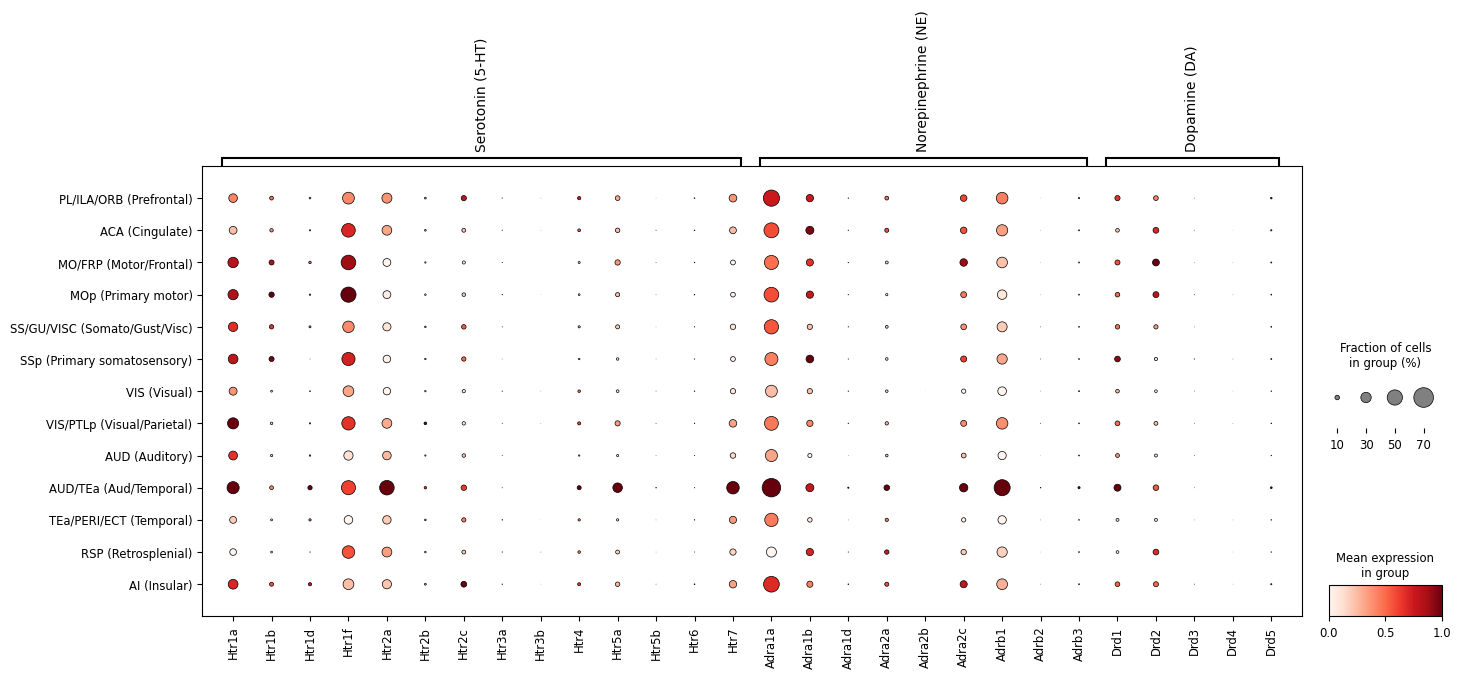

Saved: dotplot_Sst_isocortex_10x_by_region.png


In [6]:
# Build AnnData
adata_sst = anndata.AnnData(
    X=expression_data.values,
    obs=meta[['subclass', 'supertype', 'roi', 'roi_label', 'roi_category']].copy(),
    var=pd.DataFrame(index=receptor_genes)
)

adata_sst.obs['roi_label'] = pd.Categorical(
    adata_sst.obs['roi_label'], categories=sorted_roi_labels, ordered=True
)

receptor_groups = {
    'Serotonin (5-HT)': [g for g in serotonin_receptors if g in receptor_genes],
    'Norepinephrine (NE)': [g for g in norepinephrine_receptors if g in receptor_genes],
    'Dopamine (DA)': [g for g in dopamine_receptors if g in receptor_genes],
}

n_rois = len(sorted_rois)
print(f'AnnData: {adata_sst.shape[0]:,} cells × {adata_sst.shape[1]} genes, {n_rois} regions')

dp = sc.pl.dotplot(
    adata_sst,
    var_names=receptor_groups,
    groupby='roi_label',
    standard_scale='var',
    cmap='Reds',
    figsize=(16, max(5, n_rois * 0.45)),
    show=False,
    return_fig=True
)
dp.style(dot_edge_color='black', dot_edge_lw=0.5)
dp.savefig('dotplot_Sst_isocortex_10x_by_region.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: dotplot_Sst_isocortex_10x_by_region.png')

## 4. Dot Plot: Sst Supertypes Across Key Regions

In [7]:
# Supertype breakdown
adata_sst.obs['supertype_short'] = adata_sst.obs['supertype'].apply(
    lambda x: re.sub(r'^\d+\s+', '', str(x))
)

st_counts = adata_sst.obs.groupby('supertype_short', observed=True).size().sort_values(ascending=False)
print(f'Sst supertypes ({len(st_counts)}):')
for st, cnt in st_counts.items():
    print(f'  {st}: {cnt:,} cells')

Sst supertypes (23):
  Sst Gaba_4: 14,155 cells
  Sst Gaba_1: 6,729 cells
  Sst Gaba_10: 5,945 cells
  Sst Gaba_8: 4,048 cells
  Sst Gaba_7: 3,648 cells
  Sst Gaba_16: 3,537 cells
  Sst Gaba_5: 3,522 cells
  Sst Gaba_9: 3,409 cells
  Sst Gaba_13: 3,255 cells
  Sst Gaba_11: 2,535 cells
  Sst Chodl Gaba_4: 2,345 cells
  Sst Gaba_14: 1,500 cells
  Sst Gaba_12: 780 cells
  Sst Gaba_15: 472 cells
  Sst Gaba_3: 370 cells
  Sst Gaba_18: 173 cells
  Sst Chodl Gaba_2: 130 cells
  Sst Gaba_2: 109 cells
  Sst Gaba_17: 66 cells
  Sst Chodl Gaba_5: 44 cells
  Sst Gaba_19: 16 cells
  Sst Gaba_6: 9 cells
  Sst Chodl Gaba_1: 1 cells


Supertype × region combinations (≥30 cells): 140
Total cells: 53,078


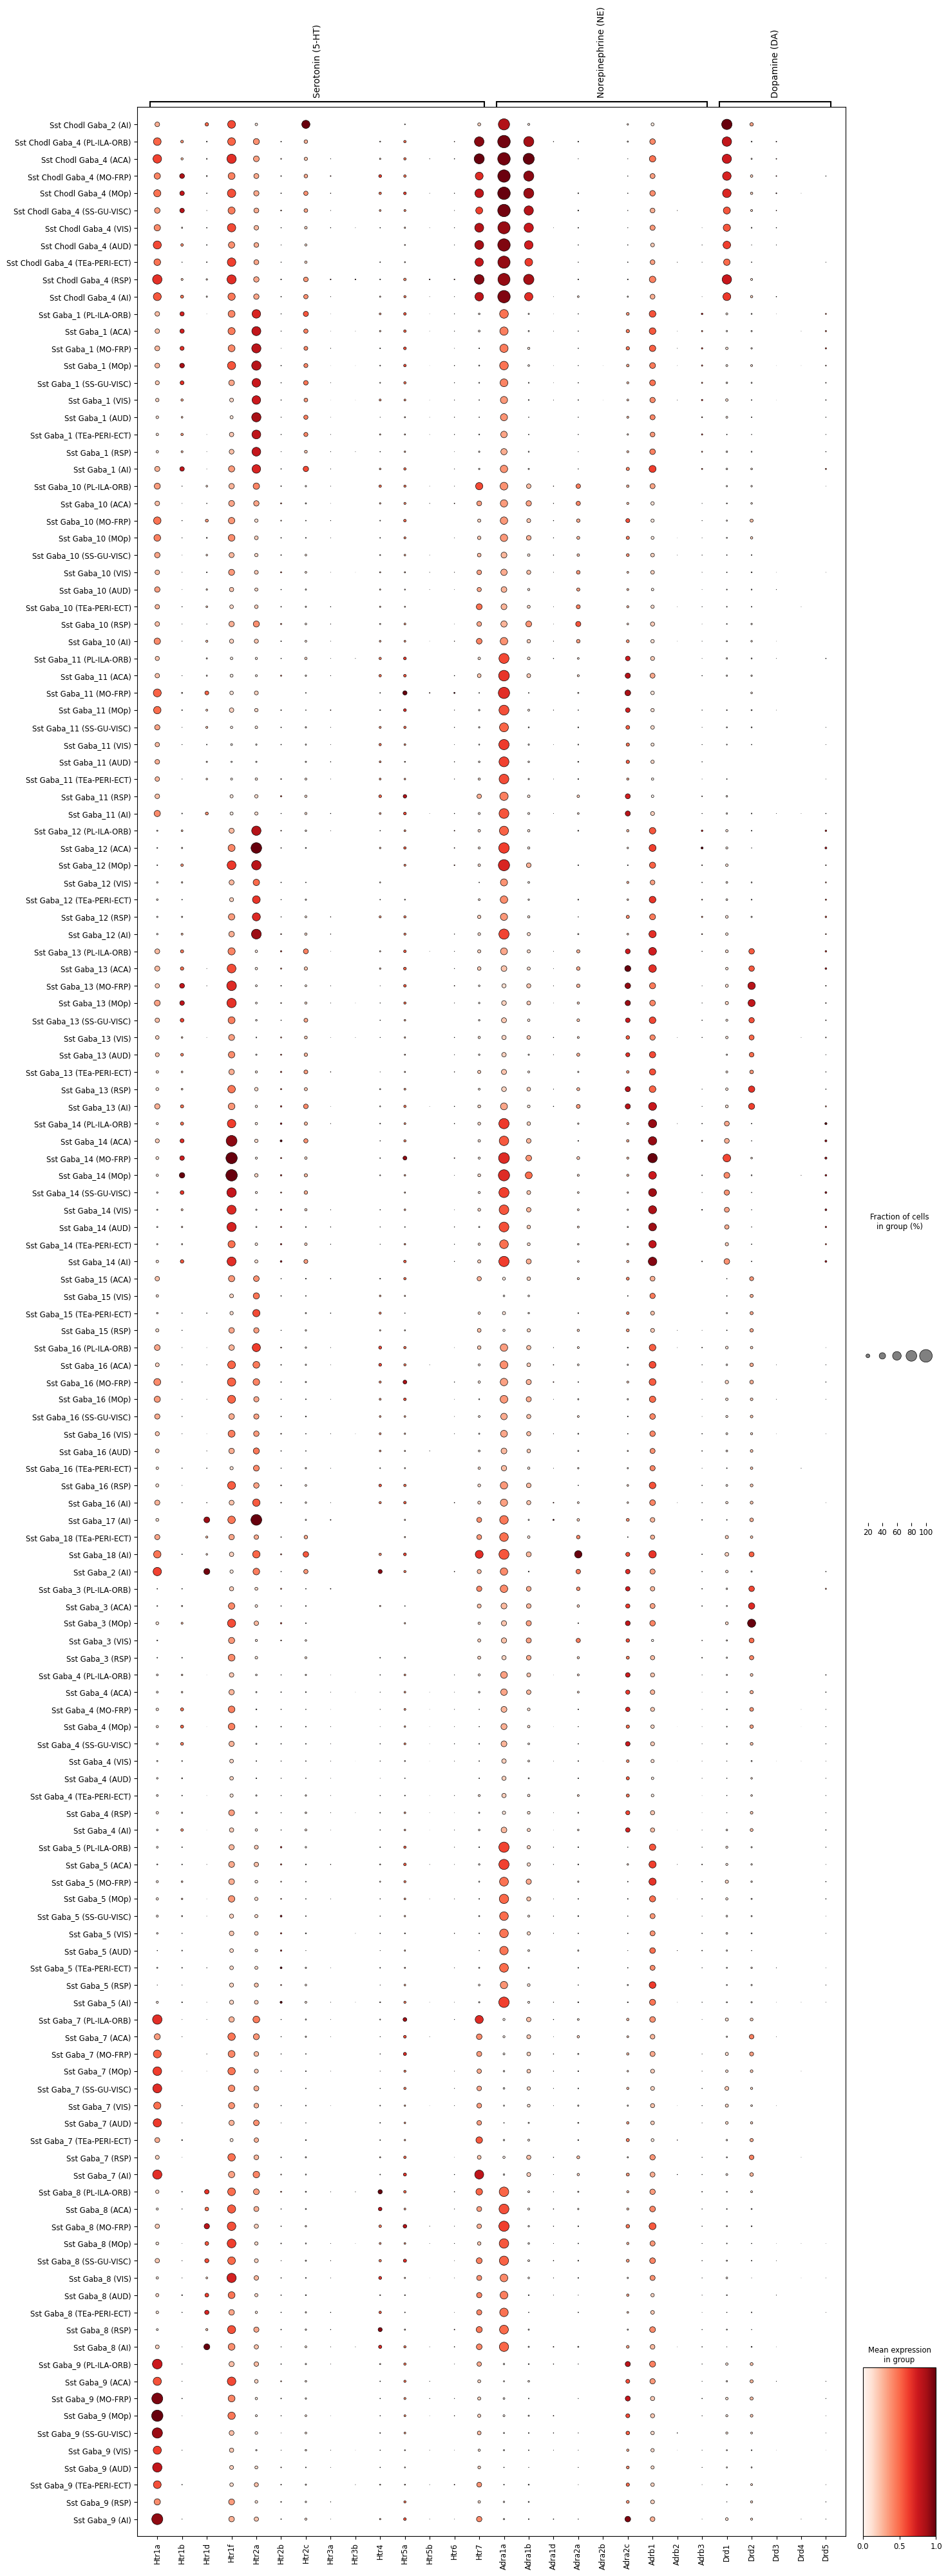

Saved: dotplot_Sst_isocortex_10x_by_supertype_region.png


In [8]:
# Select top regions by cell count for supertype comparison
key_rois = [r for r in sorted_rois if roi_counts[r] >= 2000]
if len(key_rois) < 5:
    key_rois = sorted_rois[:7]  # take top 7 if few large regions

adata_key = adata_sst[adata_sst.obs['roi'].isin(key_rois)].copy()

# Filter to supertypes with >= 50 cells in key regions
st_key_counts = adata_key.obs.groupby('supertype_short', observed=True).size()
valid_st = st_key_counts[st_key_counts >= 50].index.tolist()
adata_key = adata_key[adata_key.obs['supertype_short'].isin(valid_st)].copy()

# Combined label: supertype (region)
adata_key.obs['st_region'] = (
    adata_key.obs['supertype_short'].astype(str) + ' (' +
    adata_key.obs['roi'].astype(str) + ')'
)

# Filter to groups with >= 30 cells
combo_counts = adata_key.obs.groupby('st_region', observed=True).size()
valid_combos = combo_counts[combo_counts >= 30].index.tolist()
adata_key = adata_key[adata_key.obs['st_region'].isin(valid_combos)].copy()

# Sort by supertype then region
def combo_sort_key(name):
    parts = name.rsplit(' (', 1)
    st = parts[0]
    roi = parts[1].rstrip(')') if len(parts) > 1 else ''
    roi_idx = sorted_rois.index(roi) if roi in sorted_rois else 999
    return (st, roi_idx)

sorted_combos = sorted(valid_combos, key=combo_sort_key)
adata_key.obs['st_region'] = pd.Categorical(
    adata_key.obs['st_region'], categories=sorted_combos, ordered=True
)

n_combos = len(sorted_combos)
print(f'Supertype × region combinations (≥30 cells): {n_combos}')
print(f'Total cells: {len(adata_key):,}')

dp2 = sc.pl.dotplot(
    adata_key,
    var_names=receptor_groups,
    groupby='st_region',
    standard_scale='var',
    cmap='Reds',
    figsize=(16, max(8, n_combos * 0.35)),
    show=False,
    return_fig=True
)
dp2.style(dot_edge_color='black', dot_edge_lw=0.5)
dp2.savefig('dotplot_Sst_isocortex_10x_by_supertype_region.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: dotplot_Sst_isocortex_10x_by_supertype_region.png')

## 5. Heatmaps: Regional Variation in Sst Receptor Expression

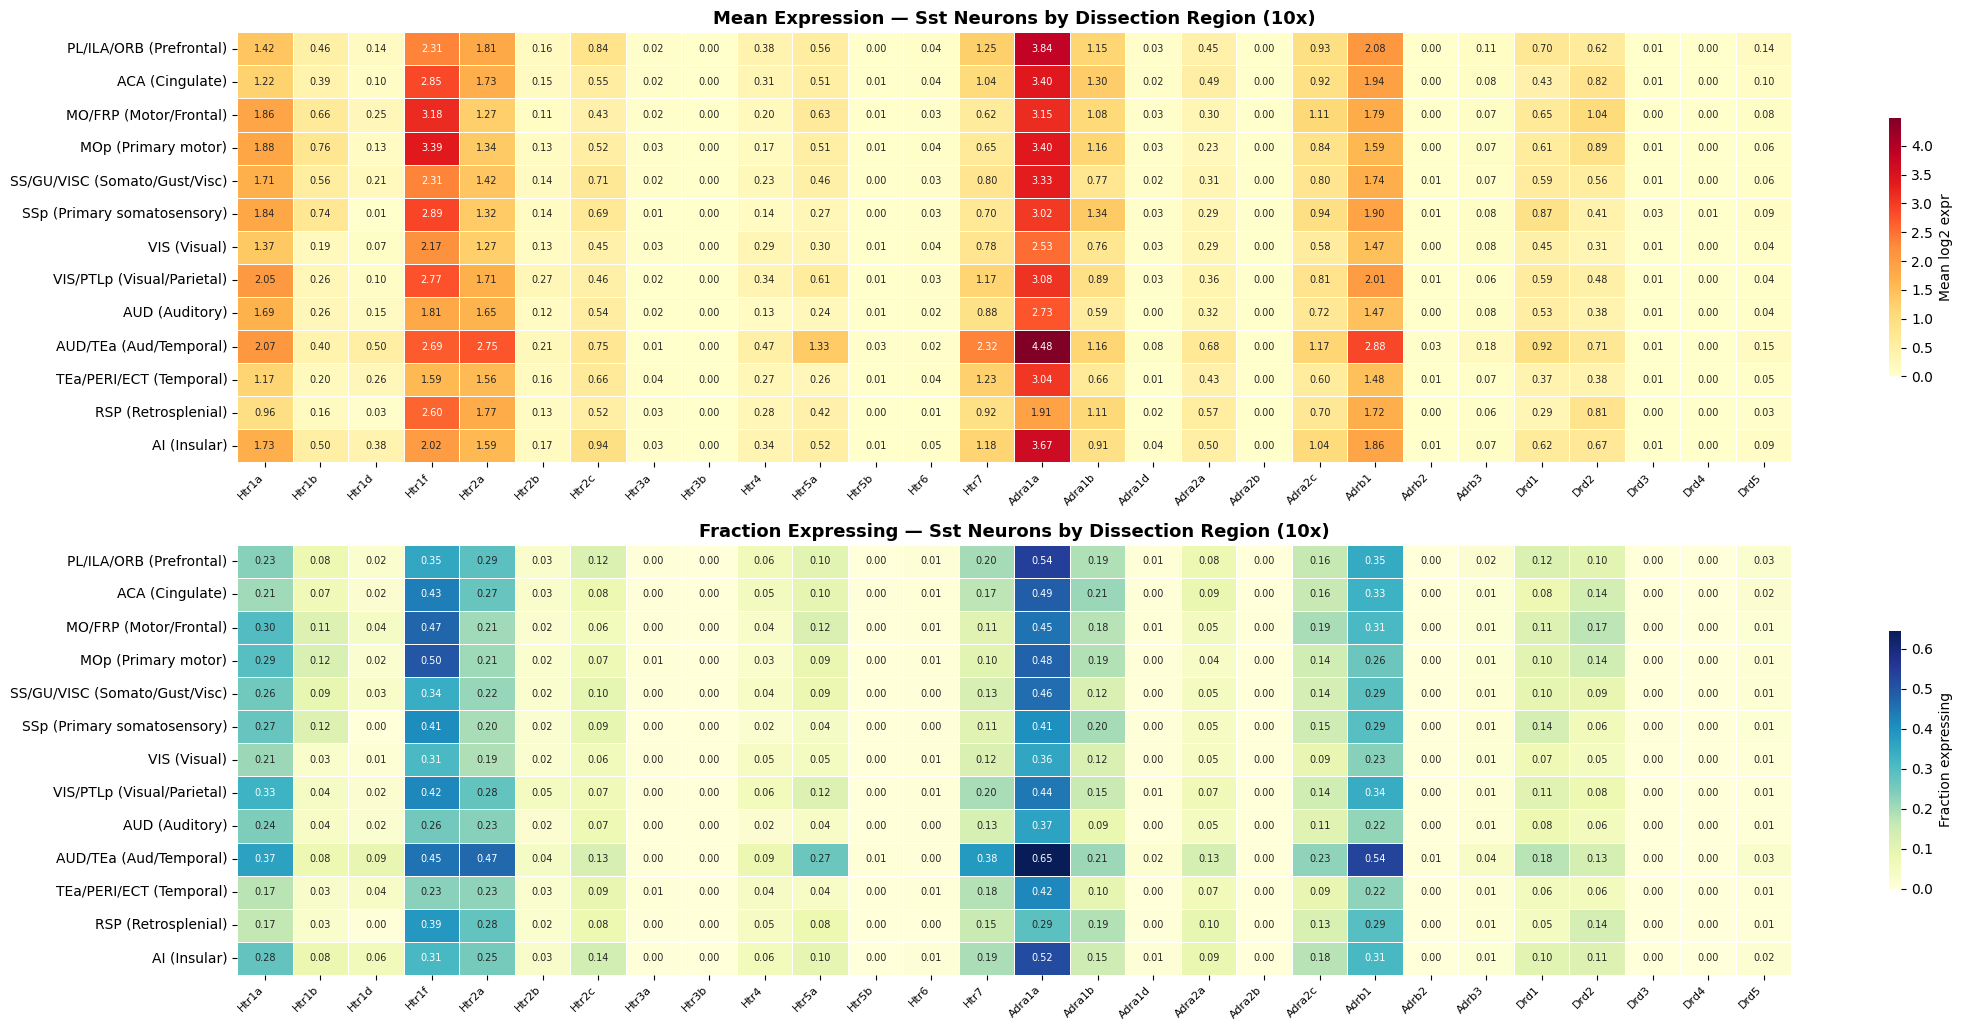

Saved: heatmap_Sst_isocortex_10x.png


In [9]:
# Compute per-region mean expression and fraction expressing
expr_df = pd.DataFrame(adata_sst.X, index=adata_sst.obs.index, columns=receptor_genes)
expr_df['roi'] = adata_sst.obs['roi'].values
expr_df['roi_label'] = adata_sst.obs['roi_label'].values

region_mean = expr_df.groupby('roi_label', observed=True)[receptor_genes].mean()
region_frac = expr_df.groupby('roi_label', observed=True)[receptor_genes].apply(lambda x: (x > 0).mean())

# Reorder
region_mean = region_mean.loc[sorted_roi_labels]
region_frac = region_frac.loc[sorted_roi_labels]

# Heatmaps side by side for 28 genes - split into two rows
fig, axes = plt.subplots(2, 1, figsize=(22, max(5, n_rois * 0.4) * 2))

sns.heatmap(region_mean, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[0],
            linewidths=0.5, cbar_kws={'label': 'Mean log2 expr', 'shrink': 0.6},
            annot_kws={'size': 7})
axes[0].set_title('Mean Expression — Sst Neurons by Dissection Region (10x)', fontweight='bold', fontsize=13)
axes[0].set_ylabel('')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=8)

sns.heatmap(region_frac, annot=True, fmt='.2f', cmap='YlGnBu', ax=axes[1],
            linewidths=0.5, cbar_kws={'label': 'Fraction expressing', 'shrink': 0.6},
            annot_kws={'size': 7})
axes[1].set_title('Fraction Expressing — Sst Neurons by Dissection Region (10x)', fontweight='bold', fontsize=13)
axes[1].set_ylabel('')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.savefig('heatmap_Sst_isocortex_10x.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: heatmap_Sst_isocortex_10x.png')

In [10]:
# Coefficient of variation across regions for each gene
cv_frac = region_frac.std() / region_frac.mean()
cv_mean = region_mean.std() / region_mean.mean()

print('Regional variation in Sst receptor expression (CV across dissection regions):')
print(f'\n{"Gene":>10s}  {"CV(frac)":>10s}  {"CV(mean)":>10s}  {"Min frac":>10s}  {"Max frac":>10s}  {"Range":>10s}')
print('-' * 65)
for g in receptor_genes:
    print(f'{g:>10s}  {cv_frac[g]:>10.3f}  {cv_mean[g]:>10.3f}  '
          f'{region_frac[g].min():>10.3f}  {region_frac[g].max():>10.3f}  '
          f'{region_frac[g].max() - region_frac[g].min():>10.3f}')

print(f'\nMost variable (fraction expressing): {cv_frac.idxmax()} (CV={cv_frac.max():.3f})')
print(f'Most conserved (fraction expressing): {cv_frac.idxmin()} (CV={cv_frac.min():.3f})')

Regional variation in Sst receptor expression (CV across dissection regions):

      Gene    CV(frac)    CV(mean)    Min frac    Max frac       Range
-----------------------------------------------------------------
     Htr1a       0.232       0.219       0.166       0.368       0.202
     Htr1b       0.481       0.489       0.029       0.124       0.095
     Htr1d       0.818       0.778       0.002       0.092       0.090
     Htr1f       0.217       0.211       0.232       0.497       0.265
     Htr2a       0.284       0.238       0.191       0.469       0.278
     Htr2b       0.334       0.285       0.018       0.049       0.031
     Htr2c       0.280       0.256       0.060       0.138       0.078
     Htr3a       0.370       0.402       0.001       0.006       0.005
     Htr3b       0.997       0.929       0.000       0.001       0.001
      Htr4       0.400       0.366       0.020       0.086       0.066
     Htr5a       0.626       0.552       0.037       0.268       0.231
   

## 6. Enrichment Heatmap: Log2 Fold-Change vs Overall Sst Mean

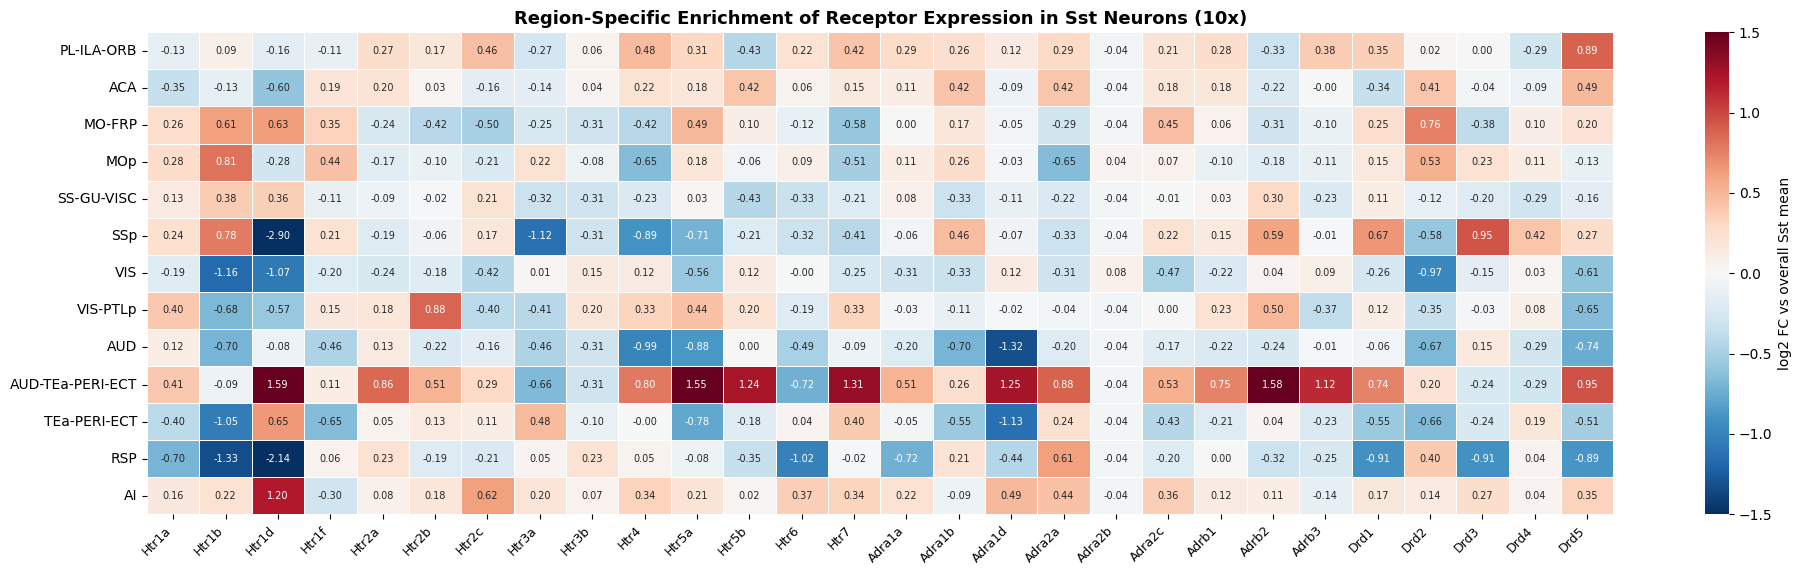

Saved: heatmap_Sst_isocortex_10x_enrichment.png

Key region-specific enrichments (|log2FC| > 0.3):
  PL-ILA-ORB               : Htr2c(+0.5), Htr4(+0.5), Htr5a(+0.3), Htr5b(-0.4), Htr7(+0.4), Adrb2(-0.3), Adrb3(+0.4), Drd1(+0.4), Drd5(+0.9)
  ACA                      : Htr1a(-0.3), Htr1d(-0.6), Htr5b(+0.4), Adra1b(+0.4), Adra2a(+0.4), Drd1(-0.3), Drd2(+0.4), Drd5(+0.5)
  MO-FRP                   : Htr1b(+0.6), Htr1d(+0.6), Htr1f(+0.4), Htr2b(-0.4), Htr2c(-0.5), Htr3b(-0.3), Htr4(-0.4), Htr5a(+0.5), Htr7(-0.6), Adra2c(+0.5), Adrb2(-0.3), Drd2(+0.8), Drd3(-0.4)
  MOp                      : Htr1b(+0.8), Htr1f(+0.4), Htr4(-0.6), Htr7(-0.5), Adra2a(-0.6), Drd2(+0.5)
  SS-GU-VISC               : Htr1b(+0.4), Htr1d(+0.4), Htr3a(-0.3), Htr3b(-0.3), Htr5b(-0.4), Htr6(-0.3), Adra1b(-0.3)
  SSp                      : Htr1b(+0.8), Htr1d(-2.9), Htr3a(-1.1), Htr3b(-0.3), Htr4(-0.9), Htr5a(-0.7), Htr6(-0.3), Htr7(-0.4), Adra1b(+0.5), Adra2a(-0.3), Adrb2(+0.6), Drd1(+0.7), Drd2(-0.6), Drd3(+0.9), Drd4(

In [11]:
# Log2 fold-change relative to overall Sst mean
overall_mean = expr_df[receptor_genes].mean()
pseudocount = 0.01

# Use ROI-keyed data for enrichment
roi_mean = expr_df.groupby('roi', observed=True)[receptor_genes].mean()
roi_mean = roi_mean.loc[sorted_rois]
log2fc = np.log2((roi_mean + pseudocount) / (overall_mean + pseudocount))

fig, ax = plt.subplots(figsize=(20, max(5, n_rois * 0.45)))
sns.heatmap(log2fc, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            ax=ax, linewidths=0.5, vmin=-1.5, vmax=1.5,
            cbar_kws={'label': 'log2 FC vs overall Sst mean'},
            annot_kws={'size': 7})
ax.set_title('Region-Specific Enrichment of Receptor Expression in Sst Neurons (10x)',
             fontweight='bold', fontsize=13)
ax.set_ylabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.tight_layout()
plt.savefig('heatmap_Sst_isocortex_10x_enrichment.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: heatmap_Sst_isocortex_10x_enrichment.png')

print('\nKey region-specific enrichments (|log2FC| > 0.3):')
for roi in sorted_rois:
    hits = []
    for g in receptor_genes:
        fc = log2fc.loc[roi, g]
        if abs(fc) > 0.3:
            direction = '+' if fc > 0 else '-'
            hits.append(f'{g}({direction}{abs(fc):.1f})')
    if hits:
        print(f'  {roi:25s}: {", ".join(hits)}')

## 7. Cross-Modality Comparison: 10x vs MERFISH

Compare the 10x results to the MERFISH data for the 11 shared genes.
Since 10x has coarser regions, we map MERFISH areas to the closest 10x dissection region.

In [12]:
# Load MERFISH data for comparison
merfish_mean_csv = 'sst_isocortex_area_mean_expression.csv'
merfish_frac_csv = 'sst_isocortex_area_frac_expressing.csv'

if os.path.exists(merfish_mean_csv) and os.path.exists(merfish_frac_csv):
    merfish_mean = pd.read_csv(merfish_mean_csv, index_col=0)
    merfish_frac = pd.read_csv(merfish_frac_csv, index_col=0)
    
    # Map MERFISH areas to 10x dissection regions
    area_to_roi = {
        # PL-ILA-ORB
        'PL': 'PL-ILA-ORB', 'ILA': 'PL-ILA-ORB',
        'ORBl': 'PL-ILA-ORB', 'ORBm': 'PL-ILA-ORB', 'ORBvl': 'PL-ILA-ORB',
        # ACA
        'ACAd': 'ACA', 'ACAv': 'ACA',
        # MOp
        'MOp': 'MOp',
        # MO-FRP
        'MOs': 'MO-FRP', 'FRP': 'MO-FRP',
        # SSp
        'SSp-bfd': 'SSp', 'SSp-ll': 'SSp', 'SSp-m': 'SSp', 'SSp-n': 'SSp',
        'SSp-tr': 'SSp', 'SSp-ul': 'SSp', 'SSp-un': 'SSp',
        # SS-GU-VISC
        'SSs': 'SS-GU-VISC', 'GU': 'SS-GU-VISC', 'VISC': 'SS-GU-VISC',
        # VIS
        'VISp': 'VIS', 'VISl': 'VIS', 'VISpm': 'VIS', 'VISam': 'VIS',
        'VISrl': 'VIS', 'VISal': 'VIS', 'VISa': 'VIS', 'VISli': 'VIS',
        # VIS-PTLp
        'VISpl': 'VIS-PTLp', 'VISpor': 'VIS-PTLp',
        # AUD
        'AUDp': 'AUD', 'AUDd': 'AUD', 'AUDv': 'AUD', 'AUDpo': 'AUD',
        # TEa-PERI-ECT
        'TEa': 'TEa-PERI-ECT', 'ECT': 'TEa-PERI-ECT', 'PERI': 'TEa-PERI-ECT',
        # RSP
        'RSPd': 'RSP', 'RSPv': 'RSP', 'RSPagl': 'RSP',
        # AI
        'AId': 'AI', 'AIp': 'AI', 'AIv': 'AI',
    }
    
    # Aggregate MERFISH areas to match 10x ROIs (weighted by cell count)
    merfish_meta = pd.read_csv('sst_isocortex_merfish_metadata.csv', index_col=0)
    merfish_expr = pd.read_csv('sst_isocortex_merfish_expression.csv', index_col=0)
    
    # Add ROI mapping
    merfish_meta['roi'] = merfish_meta['parcellation_structure'].map(area_to_roi)
    merfish_expr_with_roi = merfish_expr.copy()
    merfish_expr_with_roi['roi'] = merfish_meta.loc[merfish_expr.index, 'roi']
    merfish_expr_with_roi = merfish_expr_with_roi.dropna(subset=['roi'])
    
    shared_genes = [g for g in merfish_expr.columns if g in receptor_genes]
    
    merfish_roi_mean = merfish_expr_with_roi.groupby('roi', observed=True)[shared_genes].mean()
    merfish_roi_frac = merfish_expr_with_roi.groupby('roi', observed=True)[shared_genes].apply(
        lambda x: (x > 0).mean()
    )
    
    # Get 10x data at ROI level
    tenx_roi_mean = roi_mean[shared_genes]
    tenx_roi_frac = expr_df.groupby('roi', observed=True)[shared_genes].apply(lambda x: (x > 0).mean())
    
    # Align to common ROIs
    common_rois = sorted(set(merfish_roi_mean.index) & set(tenx_roi_mean.index))
    print(f'Shared genes: {len(shared_genes)} — {shared_genes}')
    print(f'Common ROIs: {len(common_rois)} — {common_rois}')
    
    merfish_roi_mean = merfish_roi_mean.loc[common_rois]
    merfish_roi_frac = merfish_roi_frac.loc[common_rois]
    tenx_roi_mean = tenx_roi_mean.loc[common_rois]
    tenx_roi_frac = tenx_roi_frac.loc[common_rois]
else:
    print('MERFISH summary CSVs not found — skipping cross-modality comparison.')
    common_rois = []

Shared genes: 11 — ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7', 'Adra1a', 'Adra1b', 'Drd1', 'Drd2', 'Drd3', 'Drd5']
Common ROIs: 12 — ['ACA', 'AI', 'AUD', 'MO-FRP', 'MOp', 'PL-ILA-ORB', 'RSP', 'SS-GU-VISC', 'SSp', 'TEa-PERI-ECT', 'VIS', 'VIS-PTLp']


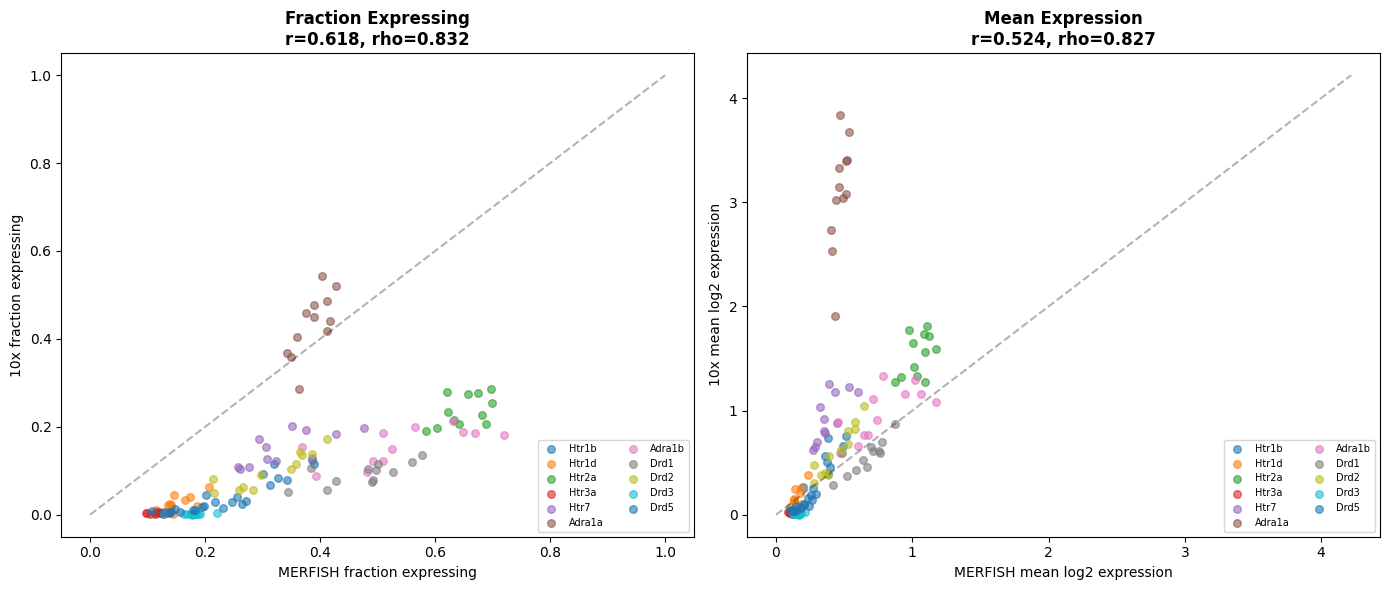

Saved: xmodal_Sst_isocortex_scatter.png

Overall cross-modality correlation (Sst isocortex):
  Fraction expressing: r=0.618, rho=0.832
  Mean expression:     r=0.524, rho=0.827


In [13]:
if len(common_rois) > 0:
    from scipy import stats
    
    # Flatten for overall scatter
    m_frac_flat = merfish_roi_frac.values.flatten()
    t_frac_flat = tenx_roi_frac.values.flatten()
    m_mean_flat = merfish_roi_mean.values.flatten()
    t_mean_flat = tenx_roi_mean.values.flatten()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Fraction scatter
    ax = axes[0]
    for gene in shared_genes:
        ax.scatter(merfish_roi_frac[gene], tenx_roi_frac[gene], alpha=0.6, s=30, label=gene)
    r_frac, p_frac = stats.pearsonr(m_frac_flat, t_frac_flat)
    rho_frac, _ = stats.spearmanr(m_frac_flat, t_frac_flat)
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax.set_xlabel('MERFISH fraction expressing')
    ax.set_ylabel('10x fraction expressing')
    ax.set_title(f'Fraction Expressing\nr={r_frac:.3f}, rho={rho_frac:.3f}', fontweight='bold')
    ax.legend(fontsize=7, ncol=2, loc='lower right')
    
    # Mean scatter
    ax = axes[1]
    for gene in shared_genes:
        ax.scatter(merfish_roi_mean[gene], tenx_roi_mean[gene], alpha=0.6, s=30, label=gene)
    r_mean, p_mean = stats.pearsonr(m_mean_flat, t_mean_flat)
    rho_mean, _ = stats.spearmanr(m_mean_flat, t_mean_flat)
    max_val = max(m_mean_flat.max(), t_mean_flat.max()) * 1.1
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3)
    ax.set_xlabel('MERFISH mean log2 expression')
    ax.set_ylabel('10x mean log2 expression')
    ax.set_title(f'Mean Expression\nr={r_mean:.3f}, rho={rho_mean:.3f}', fontweight='bold')
    ax.legend(fontsize=7, ncol=2, loc='lower right')
    
    plt.tight_layout()
    plt.savefig('xmodal_Sst_isocortex_scatter.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: xmodal_Sst_isocortex_scatter.png')
    print(f'\nOverall cross-modality correlation (Sst isocortex):')
    print(f'  Fraction expressing: r={r_frac:.3f}, rho={rho_frac:.3f}')
    print(f'  Mean expression:     r={r_mean:.3f}, rho={rho_mean:.3f}')

In [14]:
if len(common_rois) > 0:
    # Per-gene correlations across regions
    print('Per-gene cross-modality correlations (fraction expressing):')
    print(f'{"Gene":>10s}  {"Pearson r":>10s}  {"Spearman rho":>12s}')
    print('-' * 40)
    gene_corrs = []
    for gene in shared_genes:
        r, _ = stats.pearsonr(merfish_roi_frac[gene], tenx_roi_frac[gene])
        rho, _ = stats.spearmanr(merfish_roi_frac[gene], tenx_roi_frac[gene])
        gene_corrs.append({'gene': gene, 'pearson_r': r, 'spearman_rho': rho})
        print(f'{gene:>10s}  {r:>10.3f}  {rho:>12.3f}')
    
    gene_corrs_df = pd.DataFrame(gene_corrs)
    print(f'\nMedian Pearson r: {gene_corrs_df["pearson_r"].median():.3f}')
    print(f'Median Spearman rho: {gene_corrs_df["spearman_rho"].median():.3f}')

Per-gene cross-modality correlations (fraction expressing):
      Gene   Pearson r  Spearman rho
----------------------------------------
     Htr1b       0.871         0.804
     Htr1d       0.721         0.608
     Htr2a       0.488         0.441
     Htr3a      -0.012         0.000
      Htr7       0.713         0.755
    Adra1a       0.723         0.699
    Adra1b       0.682         0.622
      Drd1       0.738         0.685
      Drd2       0.910         0.902
      Drd3       0.478         0.140
      Drd5       0.856         0.832

Median Pearson r: 0.721
Median Spearman rho: 0.685


## 8. 10x-Only Genes: The Additional 17 Receptors

The 10x panel includes 17 receptor genes not in the MERFISH panel.
Examine their expression patterns across isocortex in Sst neurons.

10x-only genes (17): ['Htr1a', 'Htr1f', 'Htr2b', 'Htr2c', 'Htr3b', 'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Adra1d', 'Adra2a', 'Adra2b', 'Adra2c', 'Adrb1', 'Adrb2', 'Adrb3', 'Drd4']


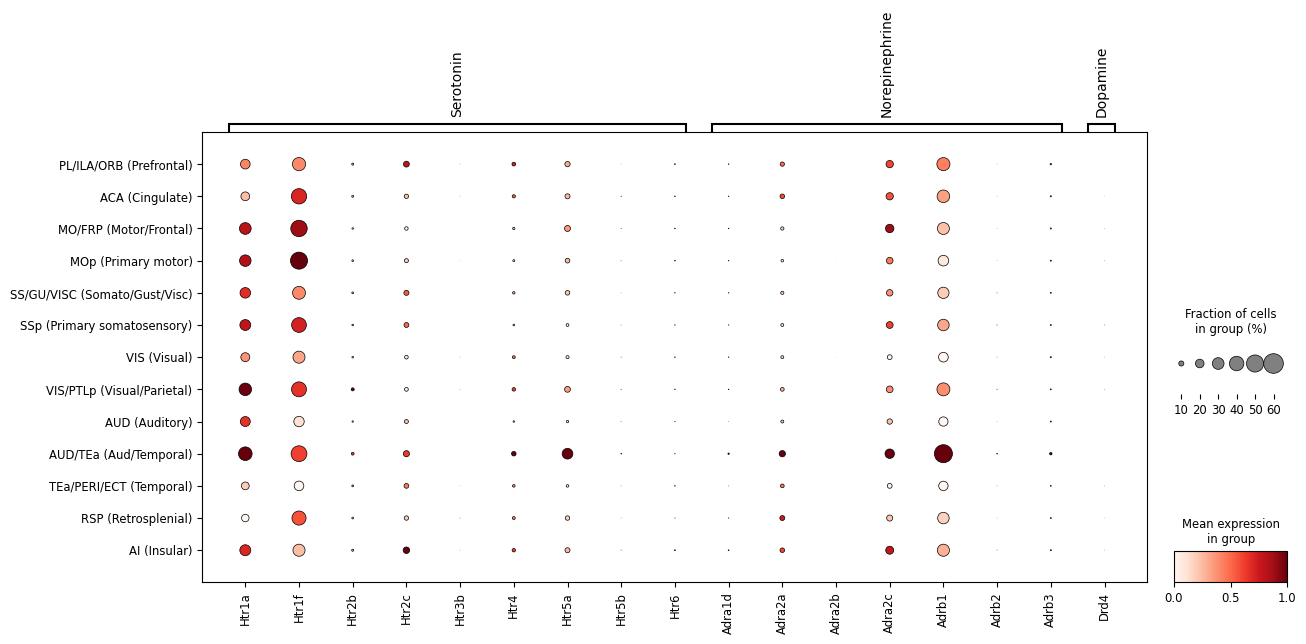

Saved: dotplot_Sst_isocortex_10x_extra_genes.png

CV of extra genes across regions (fraction expressing):
       Htr1a: CV=0.232  range=[0.166 - 0.368]
       Htr1f: CV=0.217  range=[0.232 - 0.497]
       Htr2b: CV=0.334  range=[0.018 - 0.049]
       Htr2c: CV=0.280  range=[0.060 - 0.138]
       Htr3b: CV=0.997  range=[0.000 - 0.001]
        Htr4: CV=0.400  range=[0.020 - 0.086]
       Htr5a: CV=0.626  range=[0.037 - 0.268]
       Htr5b: CV=0.959  range=[0.001 - 0.007]
        Htr6: CV=0.332  range=[0.002 - 0.009]
      Adra1d: CV=0.748  range=[0.001 - 0.017]
      Adra2a: CV=0.376  range=[0.040 - 0.133]
      Adra2b: CV=2.539  range=[0.000 - 0.000]
      Adra2c: CV=0.266  range=[0.092 - 0.226]
       Adrb1: CV=0.262  range=[0.220 - 0.535]
       Adrb2: CV=1.282  range=[0.000 - 0.007]
       Adrb3: CV=0.478  range=[0.010 - 0.037]
        Drd4: CV=0.834  range=[0.000 - 0.001]


In [15]:
if len(common_rois) > 0:
    shared_set = set(shared_genes)
else:
    shared_set = set(['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7',
                      'Adra1a', 'Adra1b', 'Drd1', 'Drd2', 'Drd3', 'Drd5'])

extra_genes = [g for g in receptor_genes if g not in shared_set]
print(f'10x-only genes ({len(extra_genes)}): {extra_genes}')

# Dot plot for extra genes only
extra_groups = {
    'Serotonin': [g for g in extra_genes if g.startswith('Htr')],
    'Norepinephrine': [g for g in extra_genes if g.startswith('Adr')],
    'Dopamine': [g for g in extra_genes if g.startswith('Drd')],
}
extra_groups = {k: v for k, v in extra_groups.items() if v}  # remove empty

dp3 = sc.pl.dotplot(
    adata_sst,
    var_names=extra_groups,
    groupby='roi_label',
    standard_scale='var',
    cmap='Reds',
    figsize=(14, max(5, n_rois * 0.45)),
    show=False,
    return_fig=True
)
dp3.style(dot_edge_color='black', dot_edge_lw=0.5)
dp3.savefig('dotplot_Sst_isocortex_10x_extra_genes.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: dotplot_Sst_isocortex_10x_extra_genes.png')

# CV for extra genes
print(f'\nCV of extra genes across regions (fraction expressing):')
for g in extra_genes:
    cv = cv_frac[g]
    fmin = region_frac[g].min()
    fmax = region_frac[g].max()
    print(f'  {g:>10s}: CV={cv:.3f}  range=[{fmin:.3f} - {fmax:.3f}]')

## 9. Summary Statistics

In [16]:
# Summary tables
print('=' * 80)
print('Mean Expression (log2) — Sst Neurons by Dissection Region (10x snRNA-seq)')
print('=' * 80)
display(roi_mean.round(3))

# Save
roi_frac = expr_df.groupby('roi', observed=True)[receptor_genes].apply(lambda x: (x > 0).mean())
roi_frac = roi_frac.loc[sorted_rois]

print('\n' + '=' * 80)
print('Fraction Expressing — Sst Neurons by Dissection Region (10x snRNA-seq)')
print('=' * 80)
display(roi_frac.round(3))

roi_mean.to_csv('sst_isocortex_10x_region_mean_expression.csv')
roi_frac.to_csv('sst_isocortex_10x_region_frac_expressing.csv')
log2fc.to_csv('sst_isocortex_10x_region_enrichment.csv')
print('\nSaved summary CSVs.')

print(f'\n{"=" * 80}')
print('Summary')
print(f'{"=" * 80}')
print(f'Total Sst cells: {len(expression_data):,}')
print(f'Dissection regions: {n_rois}')
print(f'Receptor genes: {len(receptor_genes)} ({len(extra_genes)} 10x-only)')
print(f'Most variable gene (CV frac): {cv_frac.idxmax()} (CV={cv_frac.max():.3f})')
print(f'Most conserved gene (CV frac): {cv_frac.idxmin()} (CV={cv_frac.min():.3f})')

Mean Expression (log2) — Sst Neurons by Dissection Region (10x snRNA-seq)


,Htr1a,Htr1b,Htr1d,Htr1f,Htr2a,Htr2b,Htr2c,Htr3a,Htr3b,Htr4,...,Adra2b,Adra2c,Adrb1,Adrb2,Adrb3,Drd1,Drd2,Drd3,Drd4,Drd5
roi,,,,,,,,,,,,,,,,,,,,,
PL-ILA-ORB,1.416,0.456,0.142,2.310,1.815,0.164,0.839,0.019,0.003,0.377,...,0.000,0.935,2.077,0.002,0.106,0.702,0.621,0.009,0.000,0.141
ACA,1.220,0.390,0.102,2.851,1.733,0.148,0.546,0.022,0.003,0.313,...,0.000,0.915,1.939,0.003,0.079,0.429,0.819,0.008,0.001,0.104
MO-FRP,1.857,0.660,0.252,3.180,1.270,0.106,0.427,0.020,0.000,0.198,...,0.000,1.106,1.792,0.002,0.073,0.653,1.040,0.004,0.003,0.084
MOp,1.884,0.759,0.129,3.390,1.335,0.134,0.525,0.031,0.002,0.167,...,0.001,0.844,1.592,0.003,0.073,0.609,0.887,0.012,0.003,0.065
SS-GU-VISC,1.706,0.560,0.207,2.313,1.415,0.143,0.708,0.018,0.000,0.227,...,0.000,0.802,1.744,0.008,0.066,0.591,0.563,0.006,0.000,0.063
SSp,1.839,0.741,0.013,2.888,1.321,0.138,0.688,0.006,0.000,0.140,...,0.000,0.941,1.904,0.012,0.078,0.874,0.405,0.026,0.006,0.088
VIS,1.366,0.186,0.071,2.165,1.271,0.127,0.451,0.026,0.004,0.292,...,0.001,0.578,1.471,0.005,0.085,0.455,0.307,0.007,0.002,0.044
VIS-PTLp,2.054,0.264,0.104,2.774,1.712,0.274,0.459,0.017,0.004,0.339,...,0.000,0.809,2.012,0.011,0.059,0.593,0.479,0.008,0.003,0.042
AUD,1.686,0.259,0.150,1.812,1.646,0.123,0.545,0.016,0.000,0.130,...,0.000,0.716,1.466,0.002,0.078,0.526,0.381,0.011,0.000,0.039



Fraction Expressing — Sst Neurons by Dissection Region (10x snRNA-seq)


,Htr1a,Htr1b,Htr1d,Htr1f,Htr2a,Htr2b,Htr2c,Htr3a,Htr3b,Htr4,...,Adra2b,Adra2c,Adrb1,Adrb2,Adrb3,Drd1,Drd2,Drd3,Drd4,Drd5
roi,,,,,,,,,,,,,,,,,,,,,
PL-ILA-ORB,0.234,0.079,0.025,0.354,0.286,0.029,0.120,0.003,0.001,0.065,...,0.0,0.162,0.349,0.000,0.019,0.119,0.105,0.001,0.000,0.025
ACA,0.205,0.068,0.018,0.432,0.275,0.028,0.081,0.004,0.000,0.053,...,0.0,0.160,0.332,0.000,0.015,0.076,0.137,0.001,0.000,0.019
MO-FRP,0.302,0.115,0.045,0.473,0.206,0.020,0.060,0.004,0.000,0.035,...,0.0,0.195,0.310,0.000,0.014,0.114,0.173,0.001,0.000,0.014
MOp,0.294,0.124,0.021,0.497,0.207,0.023,0.073,0.005,0.000,0.028,...,0.0,0.141,0.265,0.000,0.013,0.102,0.143,0.002,0.001,0.011
SS-GU-VISC,0.262,0.093,0.034,0.342,0.216,0.025,0.098,0.003,0.000,0.038,...,0.0,0.136,0.286,0.001,0.012,0.098,0.091,0.001,0.000,0.011
SSp,0.273,0.115,0.002,0.411,0.196,0.022,0.093,0.001,0.000,0.023,...,0.0,0.146,0.295,0.002,0.012,0.135,0.064,0.004,0.001,0.014
VIS,0.210,0.030,0.011,0.312,0.191,0.021,0.064,0.004,0.001,0.047,...,0.0,0.092,0.234,0.001,0.014,0.074,0.049,0.001,0.000,0.007
VIS-PTLp,0.329,0.045,0.019,0.417,0.277,0.049,0.067,0.003,0.001,0.060,...,0.0,0.143,0.344,0.002,0.011,0.106,0.080,0.001,0.001,0.008
AUD,0.242,0.039,0.022,0.257,0.233,0.018,0.072,0.002,0.000,0.020,...,0.0,0.107,0.220,0.000,0.012,0.080,0.057,0.002,0.000,0.006



Saved summary CSVs.

Summary
Total Sst cells: 56,798
Dissection regions: 13
Receptor genes: 28 (17 10x-only)
Most variable gene (CV frac): Adra2b (CV=2.539)
Most conserved gene (CV frac): Adra1a (CV=0.202)
